In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils import decorate
from collections import deque

In [2]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def make_ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

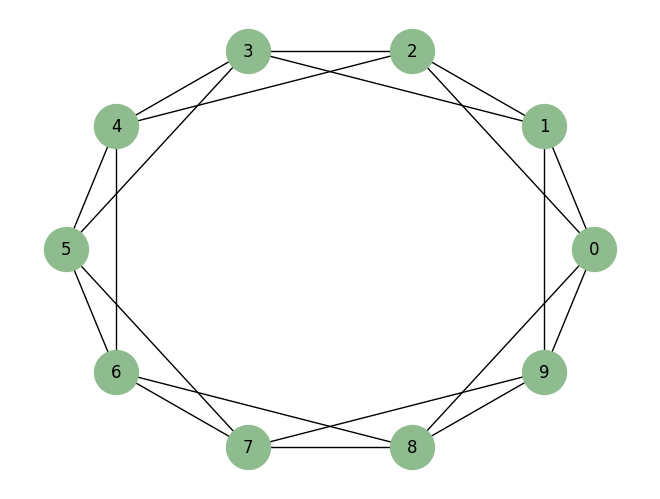

In [3]:
lattice = make_ring_lattice(10, 4)

nx.draw_circular(lattice,
                    node_color='darkseagreen',
                    node_size=1000,
                    with_labels=True)

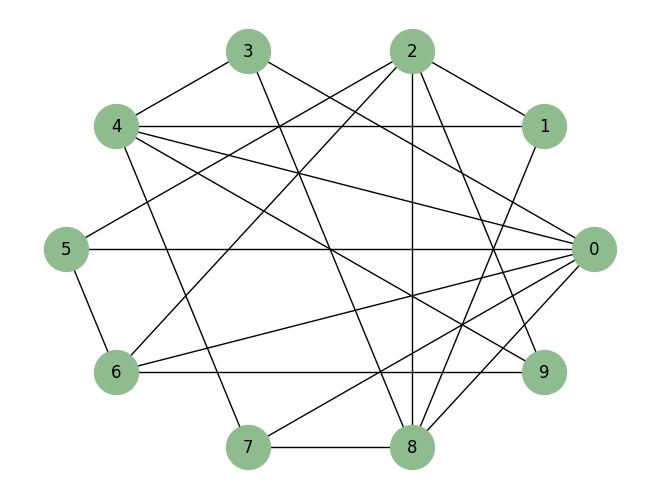

In [4]:
def flip(p):
    return np.random.random() < p


def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i>j:
                yield u,v


def rewire(G:nx.Graph, p):
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)


def make_ws_graph(n, k, p):
    ws = make_ring_lattice(n, k)
    rewire(ws, p)

    return ws


lattice = make_ring_lattice(10, 4)
rewire(lattice, 1)
nx.draw_circular(lattice,
                    node_color='darkseagreen',
                    node_size=1000,
                    with_labels=True)
                

In [5]:
def node_clustering(G:nx.Graph, u):
    neighbors = G[u]
    k = len(neighbors)
    if k<2:
        return np.nan
    
    possible = k * (k-1)/2
    exist = 0
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist += 1
    return exist/possible


def clustering_coefficient(G):
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

lattice = make_ring_lattice(10, 4)
rewire(lattice, 1)
clustering_coefficient(lattice)

0.5365079365079365

In [6]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for destination, distance in dist_map.items():
            if source != destination:
                yield distance
    

def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

lattice = make_ring_lattice(3, 2)
characteristic_path_length(lattice)

1.0

In [7]:
def run_one_graph(n, k, p):
    ws = make_ws_graph(n, k, p)
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    return mpl, cc


def run_experiment(ps, n=1000, k=10, iters=20):
    res = []
    for p in ps:
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        res.append(means)
    
    return np.array(res)


# ps = np.logspace(-4, 0, 9)
# res = run_experiment(ps)

In [8]:
# L, C = np.transpose(res)

# L /= L[0]
# C /= C[0]

# plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
# plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
# decorate(xlabel='Rewiring probability (p)', xscale='log',
#          title='Normalized clustering coefficient and path length',
#          xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

In [9]:
def reachable_nodes(G:nx.Graph, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(G.neighbors(node))
    return seen



def reachable_nodes_bfs(G:nx.Graph, start):
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
        
    return seen


def shortest_path_dijkstra(G:nx.Graph,source):
    distances = {source:0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_distance = distances[node] + 1

        neighbors = set(G[node]).difference(distances)
        for neighbor in neighbors:
            distances[neighbor] = new_distance

        queue.extend(neighbors)
    return distances

lattice = make_ws_graph(10, 4, 0.3)
shortest_path_dijkstra(lattice, 1)

{1: 0, 9: 1, 5: 1, 6: 1, 8: 2, 0: 2, 7: 2, 4: 2, 2: 3, 3: 3}

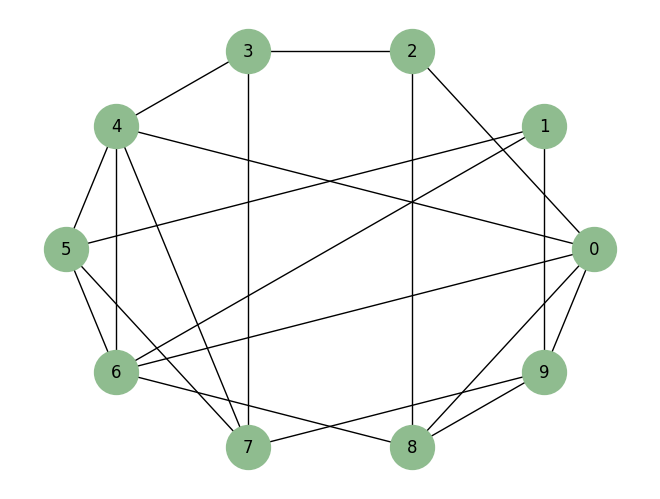

In [10]:
nx.draw_circular(lattice,
                  node_color='darkseagreen',
                  node_size=1000,
                  with_labels=True)

In [24]:
lattice.adj

AdjacencyView({0: {1: {}, 2: {}, 8: {}, 9: {}}, 1: {0: {}, 2: {}, 3: {}, 6: {}}, 2: {0: {}, 1: {}, 3: {}, 4: {}}, 3: {1: {}, 2: {}, 4: {}, 5: {}}, 4: {2: {}, 3: {}, 6: {}, 9: {}, 5: {}}, 5: {3: {}, 9: {}, 4: {}}, 6: {4: {}, 7: {}, 8: {}, 1: {}}, 7: {6: {}, 8: {}, 9: {}}, 8: {6: {}, 7: {}, 9: {}, 0: {}}, 9: {7: {}, 8: {}, 0: {}, 4: {}, 5: {}}})